In [ ]:
from scipy.io.wavfile import read, write
import torchaudio
import torch
from librosa.util import normalize
from librosa.filters import mel as librosa_mel_fn
import numpy as np
import librosa
from IPython.display import Audio
from tqdm import tqdm
import os
import soundfile as sf
import json

In [ ]:
MAX_WAV_VALUE = 32768.0

def load_wav(full_path):
    sampling_rate, data = read(full_path)
    return data, sampling_rate

def dynamic_range_compression(x, C=1, clip_val=1e-5):
    return np.log(np.clip(x, a_min=clip_val, a_max=None) * C)

def dynamic_range_decompression(x, C=1):
    return np.exp(x) / C

def dynamic_range_compression_torch(x, C=1, clip_val=1e-5):
    return torch.log(torch.clamp(x, min=clip_val) * C)

def dynamic_range_decompression_torch(x, C=1):
    return torch.exp(x) / C

def spectral_normalize_torch(magnitudes):
    output = dynamic_range_compression_torch(magnitudes)
    return output

def spectral_de_normalize_torch(magnitudes):
    output = dynamic_range_decompression_torch(magnitudes)
    return output

mel_basis = {}
hann_window = {}

def mel_spectrogram(y, n_fft, num_mels, sampling_rate, hop_size, win_size, fmin, fmax, center=False):
    if torch.min(y) < -1.:
        print('min value is ', torch.min(y))
    if torch.max(y) > 1.:
        print('max value is ', torch.max(y))

    global mel_basis, hann_window
    if fmax not in mel_basis:
        mel = librosa_mel_fn(sr=sampling_rate, n_fft=n_fft, n_mels=num_mels, fmin=fmin, fmax=fmax)
        mel_basis[str(fmax)+'_'+str(y.device)] = torch.from_numpy(mel).float().to(y.device)
        hann_window[str(y.device)] = torch.hann_window(win_size).to(y.device)

    y = torch.nn.functional.pad(y.unsqueeze(1), (int((n_fft-hop_size)/2), int((n_fft-hop_size)/2)), mode='reflect')
    y = y.squeeze(1)

    spec = torch.stft(y, n_fft, hop_length=hop_size, win_length=win_size, window=hann_window[str(y.device)],
                      center=center, pad_mode='reflect', normalized=False, onesided=True)

    spec = torch.sqrt(spec.pow(2).sum(-1)+(1e-9))

    spec = torch.matmul(mel_basis[str(fmax)+'_'+str(y.device)], spec)
    spec = spectral_normalize_torch(spec)

    return spec

In [66]:
a_add_b_1_templates = ["Add a sound effect of \{A\} at the beginning",
                        "Add \{A\} at the beginning", "Insert \{A\} at the start",
                        "Put a \{A\} sound effect at the beginning",
                        "Introduce a sound effect of \{A\} at the start",
                        "Add \{A\} in the beginning",
                        "Add \{A\} to the beginning of the audio",
                        "Add a sound effect of \{A\} to the beginning of the audio",
                        "Combine \{A\} with the initial part of the audio",
                        "Mix \{A\} with the first part of the audio",
                        "Add a short clip of \{A\} in the beginning",
                        "Add a brief sound effect of \{A\} at the start",
                        "Fuse a short sound of \{A\} to the start of the audio track",
                        "Place a short audio of \{A\} at the beginning of the audio",
                        "Add: \{A\} in the beginning",
                        "add: \{A\} in the beginning"]

In [67]:
a_add_b_2_templates = ["Insert \{A\} in the middle of the audio",
                        "Insert: \{A\} in the middle",
                        "Add a sound effect of \{A\} in the middle",
                        "Add a short clip of \{A\} in the middle",
                        "Add: \{A\} in the middle",
                        "Add \{A\} at the midpoint",
                        "Add a sound effect of \{A\} at the midpoint",
                        "Include:\{A\} in the middle section",
                        "Integrate \{A\} in the middle",
                        "Blend \{A\} with the audio at the halfway point",
                        "Mix \{A\} into the middle part",
                        "Fuse \{A\} into the audio at the midpoint",
                        "Merge \{A\} into the middle section of the audio",
                        "Combine \{A\} with the audio at the middle point",
                        "Place a \{A\} in the middle of the audio track",
                        "Merge: a short clip of \{A\} into the audio at the midpoint"]

In [68]:
a_add_b_3_templates = ["Add \{A\} at the end",
                        "Add: \{A\} with the final part",
                        "Add: \{A\} at the end",
                        "Add a short clip of \{A\} at the end",
                        "Add: a short clip of \{A\} at the end",
                        "Append \{A\} to the end",
                        "Include a sound effect of \{A\} in the end",
                        "Integrate \{A\} as the final sound of the audio",
                        "Blend \{A\} with the last part of the audio",
                        "Mix \{A\} with the final part",
                        "Mix: \{A\} with the final part",
                        "Fuse \{A\} to the end of the audio",
                        "Merge \{A\} with the closing sequence of the audio",
                        "Combine \{A\} with the final part",
                        "Place \{A\} at the end",
                        "Place a sound effect of \{A\} at the end",
                        "Place: \{A\} at the end"]

In [69]:
drop_templates = ["Drop: \{A\}", "Drop \{A\}", "Delete: \{A\}", "Delete \{A\}",
                  "Omit \{A\} from the audio", "Erase \{A\} from the track", "Erase: \{A\}",
                  "Omit: \{A\}", "Remove: \{A\}", "Trim: \{A\}", "Remove \{A\}", "Drop: \{A\}"]

In [70]:
# with open("/home/v-yuancwang/AUDIT_v2/medata_infos/fsd_short.json", "r") as f:
#     fsd_short_infos = json.load(f)
# with open("/home/v-yuancwang/AUDIT_v2/medata_infos/fsd50k_short.json", "r") as f:
#     fsd50k_short_infos = json.load(f)
# b_wav_infos = fsd_short_infos + fsd50k_short_infos
# print(len(b_wav_infos))
# # b_wav_infos[:5]

35044


In [71]:
ac_train_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/ac_train.json"
ac_val_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/ac_val.json"
audioset_sl_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/audioset_sl.json"
bbc_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/bbc.json"
soundbible_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/soundbible.json"
fsd_10s_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/fsd_10s.json"
vgg_json = "/home/v-yuancwang/AUDIT_v2/medata_infos/vggsound.json"

with open(ac_train_json, "r") as f:
    ac_train_infos = json.load(f)
with open(ac_val_json, "r") as f:
    ac_val_infos = json.load(f)
with open(audioset_sl_json, "r") as f:
    audioset_sl_infos = json.load(f)
with open(bbc_json, "r") as f:
    bbc_infos = json.load(f)
with open(bbc_json, "r") as f:
    soundbible_infos = json.load(f)
with open(bbc_json, "r") as f:
    fsd_10s_infos = json.load(f)
with open(vgg_json, "r") as f:
    vgg_infos = json.load(f)
np.random.shuffle(vgg_infos)
vgg_infos = vgg_infos[:10*1000]

print(len(ac_train_infos), len(ac_val_infos), len(audioset_sl_infos),
      len(bbc_infos), len(soundbible_infos), len(fsd_10s_infos))

seven_sets_infos = bbc_infos + soundbible_infos + fsd_10s_infos + audioset_sl_infos + ac_train_infos + ac_val_infos + vgg_infos
a_infos = []
for info in tqdm(seven_sets_infos[:]):
    if len(info["caption"].split(" ")) <= 10:
        a_infos.append(info)
print(len(a_infos))
# a_infos[:10]

45435 449 79147 11754 11754 11754


100%|██████████| 170293/170293 [00:00<00:00, 945906.49it/s]

115619


In [74]:
json_lists = []
remove_json_lists = []
add_wav_path = "/blob/v-yuancwang/AUDITDATA/add_1/wav"
add_mel_path = "/blob/v-yuancwang/AUDITDATA/add_1/mel"

for i in range(50000)[:]:

    a_id = np.random.randint(0, len(a_infos))
    b_id = np.random.randint(0, len(b_wav_infos))
    
    a_wav_path, a_caption = a_infos[a_id]["mel"].replace("/mel/", "/wav/").replace(".npy", ".wav"), a_infos[a_id]["caption"]
    b_wav_path, b_caption = b_wav_infos[b_id]["wav"], b_wav_infos[b_id]["caption"]
    # print(a_caption, b_caption)

    template = np.random.choice(a_add_b_1_templates)
    caption = template.replace("\{A\}", b_caption.lower().replace(".", ""))
    remove_caption = np.random.choice(drop_templates).replace("\{A\}", b_caption.lower().replace(".", ""))
    # print(caption)

    a_wav, sr = librosa.load(a_wav_path, sr=16000)
    b_wav, sr = librosa.load(b_wav_path, sr=16000)

    a_wav = np.pad(a_wav, (0, max(0, 16000*10-len(a_wav))), 'wrap')[:16000*10]
    pre_pad_length = np.random.randint(0, 35000)
    b_wav = np.pad(b_wav, (pre_pad_length, max(0, 16000*10-len(b_wav)-pre_pad_length)), 'constant', constant_values=(0, 0))[:16000*10]

    c_wav = a_wav + b_wav
    c_wav = np.clip(c_wav, -1, 1)

    x = torch.FloatTensor(c_wav)
    x = mel_spectrogram(x.unsqueeze(0), n_fft=1024, num_mels=80, sampling_rate=16000,
                        hop_size=256, win_size=1024, fmin=0, fmax=8000)
    spec = x.cpu().numpy()[0]
    # print(spec.shape)

    c_wav = c_wav * MAX_WAV_VALUE
    c_wav = c_wav.astype('int16')
    write(os.path.join(add_wav_path, "add_{}".format(str(i))+".wav"), 16000, c_wav)
    np.save(os.path.join(add_mel_path, "add_{}".format(str(i))+".npy"), spec)

    json_lists.append({"in_mel": a_infos[a_id]["mel"],
                       "out_mel": os.path.join(add_mel_path, "add_{}".format(str(i))+".npy"),
                       "caption": caption})
    remove_json_lists.append({"in_mel": os.path.join(add_mel_path, "add_{}".format(str(i))+".npy"),
                       "out_mel": a_infos[a_id]["mel"],
                       "caption": remove_caption})
    
with open("/home/v-yuancwang/AUDIT_v2/editing_medata_infos/add_1.json", "w") as f:
    json.dump(json_lists, f)
with open("/home/v-yuancwang/AUDIT_v2/editing_medata_infos/drop_1.json", "w") as f:
    json.dump(remove_json_lists, f)

In [44]:
import matplotlib.pyplot as plt

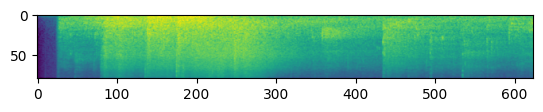

In [62]:
in_mel = np.load("/blob/v-yuancwang/WavCaps/BBC/mel/07021135.npy")[:,:624]
plt.imshow(in_mel)

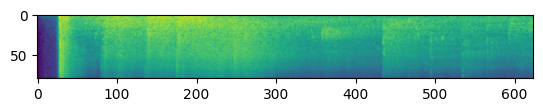

In [61]:
in_mel = np.load("/blob/v-yuancwang/AUDITDATA/add_1/mel/add_3.npy")[:,:624]
plt.imshow(in_mel)

In [47]:
# import pandas as pd

In [48]:
# dev_df =pd.read_csv("/blob/v-yuancwang/FSD50K/FSD50K.ground_truth/dev.csv")
# dev_set = {}
# for wav_id, label in zip(dev_df["fname"], dev_df["labels"]):
#     dev_set[str(wav_id)] = label.split(",")[0].replace("_", " ", 5)
# dev_set

In [49]:
# fsd50k_dev_infos = []
# fsd50k_dev_path = "/blob/v-yuancwang/FSD50K/FSD50K.dev_audio"
# fsd50k_dev_list = os.listdir(fsd50k_dev_path)

In [50]:
# for wav_id in tqdm(fsd50k_dev_list[:]):
#     wav_path = os.path.join(fsd50k_dev_path, wav_id)
#     wav, sr = librosa.load(wav_path, sr=16000)
#     if len(wav) < 16000*5.1:
#         fsd50k_dev_infos.append({"wav": wav_path, "caption": dev_set[wav_id.replace(".wav", "")]})
# fsd50k_dev_infos[:10]

In [51]:
# len(fsd50k_dev_infos)

In [52]:
# eval_df =pd.read_csv("/blob/v-yuancwang/FSD50K/FSD50K.ground_truth/eval.csv")
# eval_set = {}
# for wav_id, label in zip(eval_df["fname"], eval_df["labels"]):
#     eval_set[str(wav_id)] = label.split(",")[0].replace("_", " ", 5)
# eval_set

In [53]:
# fsd50k_eval_infos = []
# fsd50k_eval_path = "/blob/v-yuancwang/FSD50K/FSD50K.eval_audio"
# fsd50k_eval_list = os.listdir(fsd50k_eval_path)

In [54]:
# for wav_id in tqdm(fsd50k_eval_list[:]):
#     wav_path = os.path.join(fsd50k_eval_path, wav_id)
#     wav, sr = librosa.load(wav_path, sr=16000)
#     if len(wav) < 16000*5.1:
#         fsd50k_eval_infos.append({"wav": wav_path, "caption": eval_set[wav_id.replace(".wav", "")]})
# fsd50k_eval_infos[:10]

In [55]:
# print(len(fsd50k_eval_infos))

In [56]:
# fsd50k_short_infos = fsd50k_dev_infos + fsd50k_eval_infos

In [57]:
# with open("/home/v-yuancwang/AUDIT_v2/medata_infos/fsd50k_short.json", "w") as f:
#     json.dump(fsd50k_short_infos, f)

In [58]:
# Audio("/blob/v-yuancwang/FSD50K/FSD50K.dev_audio/117942.wav")